# Assignment 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from mat4py import loadmat
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dense
from keras.layers import Dropout
import numpy
numpy.random.seed(1905)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import ParameterGrid

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Take dataset

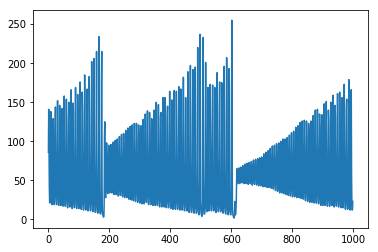

In [3]:
ts = loadmat('Xtrain.mat')
         
ts2 = pd.DataFrame(ts)       

ts3 = pd.DataFrame(ts2.Xtrain.tolist(), columns=['target']).reset_index(drop=False)  
time_series = ts3.rename(index=str, columns={"index": "time"})

plt.plot(time_series.time, time_series.target)
plt.show()

## Functions

In [17]:
#Functions for models 
#k is the window size for previous observed values which will be used as variables

def create_variables(data1, k):
    data2 = data1.copy(); 
    
    for l in range(k):
        data2[l] = data1['target'].shift(l+1)
               
    return data2

### Neural Network with 1 Hidden Layer

In [18]:
#Neural Network with 1-Hidden Layer ********************
#Initially, single fully connected hidden layer is tried with selected activation function    
#Since it's a regression problem we don't need any transformation in the output layer
#Adam is selected as optimization method: 
#Others can be tried after checking performance of Adam, otherwise number of runs would be much more higher in grid search below)
#Dropout method is selected for regularization (due to the same reason above)
    
def simple_nn(num_nodes, k, activation_func, dropout_rate, init):
 
    #num_nodes: number of nodes in the hidden layer
    #k: number of variables/inputs coming from previous values
    #activation_func: type of activation functions in the hidden layer (relu, sigmoid)
    #dropout_rate: drop out rate (warning: this is probability of turning off)
    #init: weight initialization (uniform, normal)
    
    #Create model
    model = Sequential()
    model.add(Dense(num_nodes, input_dim=k, kernel_initializer=init, activation=activation_func))  
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_initializer=init, activation='linear'))
    
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

### Validation set

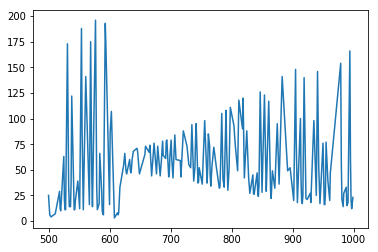

In [19]:
#Different values for k will be tried to find the best window size (variables)
#Therefore, 200 observations (~%20) after time=500 were selected randomly, in order to validate all models by the same set
#CV in grid search takes much more time and we would like to evaluate best h-parameters and k values on the same data points  
#Since real test set will be provided later, we'll use this to choose the best h-parameters set
#Remaining observations will be used in training of NNs if they are not including empty variables (previous obs)

val_times = time_series[500:].sample(n=200, random_state=1905).sort_values('time')     

plt.plot(val_times.time, val_times.target)
plt.show()    

### Variable creation and train/validation splits

In [20]:
def prepare_datasets(data1, k): 
    
    #data1: time series data set 
    #k: number of variables/inputs 
    
    data2 = create_variables(data1, k)
    
    #take the rows in val_times as val_data and others as train_data
    val_data = data2[data2['time'].isin(val_times.time)]
    train_data = data2[~data2['time'].isin(val_times.time)]
    
    #create Xs and Ys
    y_train = pd.DataFrame(train_data.target)
    X_train = pd.DataFrame(train_data.drop(['time','target'], axis=1))
    
    #for training, eliminate observations with null variables located at the first k rows (they won't be used in training since they have null values)       
    X_train = X_train[k:].reset_index(drop=True) 
    y_train = y_train[k:].reset_index(drop=True)

    y_val = pd.DataFrame(val_data.target).reset_index(drop=True)
    X_val = pd.DataFrame(val_data.drop(['time','target'], axis=1)).reset_index(drop=True)
    
    return X_train, y_train, X_val, y_val

### Grid Search

In [21]:
##Runs with grid search and evaluation on the validation set

def lets_go_grid(data1, epochs1, batch_size1):
    
    #initialize 
    output = pd.DataFrame(); 
    counter1 = 0
    k_list = [1, 5, 10, 15, 20, 30, 50, 100, 200, 400]
    
    for k1 in k_list:
        print('go for: '+str(k1))
    
        #create train/val
        X_train, y_train, X_val, y_val = prepare_datasets(data1, k1)
    
        #define the grid search parameters and model
        grid = ParameterGrid({"num_nodes": [3, 5, 10, 15, 20, 25, 30],
                          "k": [k1],
                          "activation_func":['relu'], #sigmoid was worse in initial trials so ignored
                          "dropout_rate": [0, 0.25],
                          "init": ['normal', 'uniform']})

        for params in grid:
            counter1 = counter1 + 1
            print(params)
            model = KerasRegressor(build_fn=simple_nn, epochs=epochs1, batch_size=batch_size1, verbose=0, **params)
            model.fit(X_train, y_train)
            
            #prediction on validation
            predictions = model.predict(X_val)
            predictions = pd.DataFrame(predictions)
            #evaluation
            comparison = pd.concat([y_val, predictions], axis = 1)
            comparison = comparison.rename(columns={0: 'predictions'}).reset_index(drop=False)

            comparison.plot(x='index', y=['target', 'predictions'], label=['target', 'predictions'])
            plt.show()

            mse = mean_squared_error(comparison.target,comparison.predictions)
            r_squared = r2_score(comparison.target,comparison.predictions)
            
            output1 = {'run': counter1, 
                       'k': k1, 
                       'num_nodes': params['num_nodes'],
                       'activation_func': params['activation_func'],
                       'dropout_rate': params['dropout_rate'],
                       'init': params['init'],
                       
                       'mse' : mse, 
                       'r2': r_squared 
                        }
            
            output1 = pd.DataFrame(output1, index=[0])
            
            output = pd.concat([output, output1], axis=0)
            
    return output

### Grid Search for 1 Hidden Layer NN
(results are attached in Excel file)

In [ ]:
#Run grid search for 1-hidden layer NN (warning: it takes time, faster in Google colab)
grid_results1 = lets_go_grid(time_series, 200, 50) 

#to excel 
#writer = pd.ExcelWriter('grid_results.xlsx', engine='xlsxwriter');
#grid_results1.to_excel(writer, sheet_name= 'grid_results');
#writer.save(); 

### Evaluation

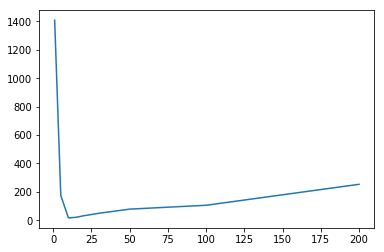

,run,k,num_nodes,activation_func,dropout_rate,init,mse,r2
0,70,10,30,relu,0.0,uniform,16.083865,0.990367
1,63,10,30,relu,0.0,normal,18.227323,0.989084
2,69,10,25,relu,0.0,uniform,19.298370,0.988442
3,90,15,25,relu,0.0,normal,20.480990,0.987734
4,89,15,20,relu,0.0,normal,21.578858,0.987076
5,88,15,15,relu,0.0,normal,23.667670,0.985825
6,62,10,25,relu,0.0,normal,25.634940,0.984647
7,94,15,10,relu,0.0,uniform,27.986054,0.983239
8,118,20,25,relu,0.0,normal,31.272762,0.981271
9,66,10,10,relu,0.0,uniform,32.087638,0.980783


In [4]:
#Grid search evaluation of 1-hidden layer NN based on MSE

eval_results = pd.read_excel('grid_results.xlsx').reset_index(drop=True)

best_of_ks = eval_results.groupby(['k'])['mse'].min().reset_index(drop=False).sort_values('k')

plt.plot(best_of_ks.k, best_of_ks.mse)
plt.show()   

#top 10 h-parameters sets
top10 = eval_results.sort_values('mse')
top10.head(10)

### Best hyperparameter set

Epoch 1/200
790/790 [==============================] - 1s 2ms/step - loss: 5599.4382 - mean_squared_error: 5599.4382
Epoch 2/200
790/790 [==============================] - 0s 51us/step - loss: 4623.5068 - mean_squared_error: 4623.5068
Epoch 3/200
790/790 [==============================] - 0s 54us/step - loss: 3387.7642 - mean_squared_error: 3387.7642
Epoch 4/200
790/790 [==============================] - 0s 57us/step - loss: 2442.9559 - mean_squared_error: 2442.9559
Epoch 5/200
790/790 [==============================] - 0s 58us/step - loss: 1917.0586 - mean_squared_error: 1917.0586
Epoch 6/200
790/790 [==============================] - 0s 65us/step - loss: 1501.2846 - mean_squared_error: 1501.2846
Epoch 7/200
790/790 [==============================] - 0s 63us/step - loss: 1175.5492 - mean_squared_error: 1175.5492
Epoch 8/200
790/790 [==============================] - 0s 56us/step - loss: 939.0573 - mean_squared_error: 939.0573
Epoch 9/200
790/790 [==============================] - 0s 5

Epoch 71/200
790/790 [==============================] - 0s 56us/step - loss: 103.8300 - mean_squared_error: 103.8300
Epoch 72/200
790/790 [==============================] - 0s 47us/step - loss: 98.9072 - mean_squared_error: 98.9072
Epoch 73/200
790/790 [==============================] - 0s 48us/step - loss: 97.4292 - mean_squared_error: 97.4292
Epoch 74/200
790/790 [==============================] - 0s 47us/step - loss: 94.4761 - mean_squared_error: 94.4761
Epoch 75/200
790/790 [==============================] - 0s 47us/step - loss: 90.1605 - mean_squared_error: 90.1605
Epoch 76/200
790/790 [==============================] - 0s 50us/step - loss: 87.0961 - mean_squared_error: 87.0961
Epoch 77/200
790/790 [==============================] - 0s 51us/step - loss: 85.2303 - mean_squared_error: 85.2303
Epoch 78/200
790/790 [==============================] - 0s 47us/step - loss: 82.7652 - mean_squared_error: 82.7652
Epoch 79/200
790/790 [==============================] - 0s 48us/step - loss: 8

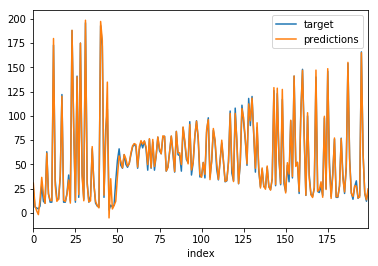

In [25]:
#Best h-parameters for 1-hidden layer NN 

#num_nodes: 30
#k: 10
#activation_func: Relu
#dropout_rate: 0
#init: weight initialization; Uniform

model = simple_nn(30, 10, 'relu', 0, 'uniform')

#create train/validation
X_train, y_train, X_val, y_val = prepare_datasets(time_series, 10)

#fit on train set
model.fit(X_train, y_train, epochs=200, batch_size=50, verbose=1)

#validation set results 
predictions = model.predict(X_val)
predictions = pd.DataFrame(predictions)

comparison = pd.concat([y_val, predictions], axis = 1)
comparison = comparison.rename(columns={0: 'predictions'}).reset_index(drop=False)
comparison.plot(x='index', y=['target', 'predictions'], label=['target', 'predictions'])
plt.show()

mse_1hl = mean_squared_error(comparison.target,comparison.predictions)
r_squared_1hl = r2_score(comparison.target,comparison.predictions)

### Prediction of next 200 points recursively 

In [28]:
def predict_next_x(data1, k, x, model1):
    
    #data1: initial training data
    #k: number of previous points as variables
    #x: number of following points that we are predicting
    #model1: final selected model 
    
    #take last k points of training data 
    vertical_data = data1.tail(k).reset_index(drop=True)
    
    #initialize and append prediction points 
    empty = pd.DataFrame(index=range(x),columns=range(1)).reset_index(drop=False)
    empty = empty.rename(index=str, columns={"index": "time", 0: "target"})
    #initially target is 0
    empty['target'] = 0 
    
    vertical_data = vertical_data.append(empty).reset_index(drop=True)
    
    for x1 in range(x):
        
        horizontal_data = create_variables(vertical_data, k)
        #take only variables for x1 
        variables = pd.DataFrame(horizontal_data[horizontal_data.time == x1])
        variables = variables.drop(['time','target'], axis=1)
        #predict test time of x1 
        prediction =  model1.predict(variables)
        #update target in x1 and recursion
        vertical_data.loc[vertical_data['time'] == x1, 'target'] = prediction
        
    return vertical_data, horizontal_data         

In [29]:
vertical_data, horizontal_data = predict_next_x(time_series, 10, 200, model);        
        
last_predictions = vertical_data.tail(200).reset_index(drop=True)        
last_predictions = last_predictions.rename(columns={'target': 'predictions'})  

### Neural Network with 2 Hidden Layers

In [32]:
#Neural Network with 2-Hidden Layers ********************

def simple_nn(num_nodes, k, activation_func, dropout_rate, init):
 
    #num_nodes: number of nodes in the hidden layer
    #k: number of variables/inputs coming from previous values (from 1 to 50)
    #activation_func: type of activation functions in the hidden layer (relu, sigmoid)
    #dropout_rate: drop out rate (warning: this is probability of turning off)
    #init: weight initialization (uniform, normal)
    
    #Create model
    model = Sequential()
    model.add(Dense(num_nodes, input_dim=k, kernel_initializer=init, activation=activation_func))  
    #second hidden layer
    model.add(Dense(num_nodes, input_dim=k, kernel_initializer=init, activation=activation_func))  
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_initializer=init, activation='linear'))
    
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model  


##Runs with grid search and evaluation on the validation set (2-Hidden Layers)
def lets_go_grid(data1, epochs1, batch_size1):
    
    #initialize 
    output = pd.DataFrame(); 
    counter1 = 0
    k_list = [20, 24, 50, 100, 200, 400]
    
    for k1 in k_list:
        print('go for: '+str(k1))
    
        #create train/val
        X_train, y_train, X_val, y_val = prepare_datasets(data1, k1)
    
        #define the grid search parameters and model 
        grid = ParameterGrid({"num_nodes": [3, 5, 6, 8, 9, 20],
                          "k": [k1],
                          "activation_func":['relu'],
                          "dropout_rate": [0],
                          "init": ['normal', 'uniform']})

        for params in grid:
            counter1 = counter1 + 1
            print(params)
            model = KerasRegressor(build_fn=simple_nn, epochs=epochs1, batch_size=batch_size1, verbose=0, **params)
            model.fit(X_train, y_train)
            
            #prediction on validation
            predictions = model.predict(X_val)
            predictions = pd.DataFrame(predictions)
            #evaluation
            comparison = pd.concat([y_val, predictions], axis = 1)
            comparison = comparison.rename(columns={0: 'predictions'}).reset_index(drop=False)

            comparison.plot(x='index', y=['target', 'predictions'], label=['target', 'predictions'])
            plt.show()

            mse = mean_squared_error(comparison.target,comparison.predictions)
            r_squared = r2_score(comparison.target,comparison.predictions)
            
            output1 = {'run': counter1, 
                       'k': k1, 
                       'num_nodes': params['num_nodes'],
                       'activation_func': params['activation_func'],
                       'dropout_rate': params['dropout_rate'],
                       'init': params['init'],
                       
                       'mse' : mse, 
                       'r2': r_squared 
                        }
            
            output1 = pd.DataFrame(output1, index=[0])
            
            output = pd.concat([output, output1], axis=0)
            
    return output    

### Grid Search for 2 Hidden Layers NN
(results are attached in Excel file)

In [ ]:
#%%
#Run grid search for 2-hidden layers NN (warning: it takes time, faster in Google colab)
grid_results2 = lets_go_grid(time_series, 200, 50) 
#to excel 
#writer = pd.ExcelWriter('results_2hl.xlsx', engine='xlsxwriter');
#grid_results2.to_excel(writer, sheet_name= 'grid_results');
#writer.save();

### Evaluation

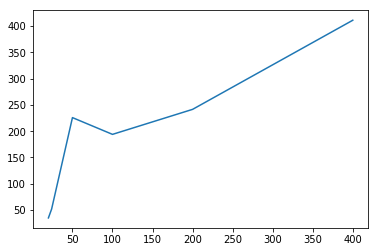

,run,k,num_nodes,activation_func,dropout_rate,init,mse,r2
4,5,20,9,relu,0,normal,35.199549,0.978919
10,11,24,9,relu,0,normal,52.055270,0.968824
9,10,24,8,relu,0,normal,74.974762,0.955097
5,6,20,20,relu,0,normal,83.215030,0.950162
7,8,24,5,relu,0,normal,192.958068,0.884436
21,22,100,8,relu,0,normal,193.925373,0.883857
23,24,100,20,relu,0,normal,225.739735,0.864803
17,18,50,20,relu,0,normal,225.757141,0.864793
6,7,24,3,relu,0,normal,233.036381,0.860433
1,2,20,5,relu,0,normal,241.041071,0.855639


In [33]:
#Grid search evaluation of 2-hidden layers NN based on MSE

eval_results = pd.read_excel('results_2hl.xlsx').reset_index(drop=True)

best_of_ks = eval_results.groupby(['k'])['mse'].min().reset_index(drop=False).sort_values('k')

plt.plot(best_of_ks.k, best_of_ks.mse)
plt.show()   

#top 10 h-parameters sets
top10 = eval_results.sort_values('mse')
top10.head(10)

Epoch 1/200
780/780 [==============================] - 1s 2ms/step - loss: 6031.8173 - mean_squared_error: 6031.8173
Epoch 2/200
780/780 [==============================] - 0s 63us/step - loss: 5962.6472 - mean_squared_error: 5962.6472
Epoch 3/200
780/780 [==============================] - 0s 65us/step - loss: 5671.1305 - mean_squared_error: 5671.1305
Epoch 4/200
780/780 [==============================] - 0s 70us/step - loss: 4883.5708 - mean_squared_error: 4883.5708
Epoch 5/200
780/780 [==============================] - 0s 69us/step - loss: 3601.0049 - mean_squared_error: 3601.0049
Epoch 6/200
780/780 [==============================] - 0s 62us/step - loss: 2647.9061 - mean_squared_error: 2647.9061
Epoch 7/200
780/780 [==============================] - 0s 64us/step - loss: 2248.1416 - mean_squared_error: 2248.1416
Epoch 8/200
780/780 [==============================] - 0s 66us/step - loss: 1881.2312 - mean_squared_error: 1881.2312
Epoch 9/200
780/780 [==============================] - 0s

780/780 [==============================] - 0s 61us/step - loss: 69.1144 - mean_squared_error: 69.1144
Epoch 141/200
780/780 [==============================] - 0s 60us/step - loss: 69.3897 - mean_squared_error: 69.3897
Epoch 142/200
780/780 [==============================] - 0s 55us/step - loss: 69.7490 - mean_squared_error: 69.7490
Epoch 143/200
780/780 [==============================] - 0s 54us/step - loss: 68.9172 - mean_squared_error: 68.9172
Epoch 144/200
780/780 [==============================] - 0s 56us/step - loss: 67.9675 - mean_squared_error: 67.9675
Epoch 145/200
780/780 [==============================] - 0s 54us/step - loss: 66.3946 - mean_squared_error: 66.3946
Epoch 146/200
780/780 [==============================] - 0s 55us/step - loss: 66.3446 - mean_squared_error: 66.3446
Epoch 147/200
780/780 [==============================] - 0s 55us/step - loss: 65.6897 - mean_squared_error: 65.6897
Epoch 148/200
780/780 [==============================] - 0s 54us/step - loss: 65.4514 

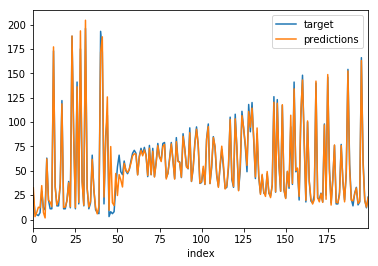

In [34]:
#Best h-parameters for 2-hidden layers NN 

#num_nodes: 9
#k: 20
#activation_func: Relu
#dropout_rate: 0
#init: weight initialization; Normal

model = simple_nn(9, 20, 'relu', 0, 'normal')

#create train/validation
X_train, y_train, X_val, y_val = prepare_datasets(time_series, 20)

#fit on train set
model.fit(X_train, y_train, epochs=200, batch_size=50, verbose=1)

#validation set results 
predictions = model.predict(X_val)
predictions = pd.DataFrame(predictions)

comparison = pd.concat([y_val, predictions], axis = 1)
comparison = comparison.rename(columns={0: 'predictions'}).reset_index(drop=False)
comparison.plot(x='index', y=['target', 'predictions'], label=['target', 'predictions'])
plt.show()

mse_2hl = mean_squared_error(comparison.target,comparison.predictions)
r_squared_2hl = r2_score(comparison.target,comparison.predictions)

#MSE on validation set of best model of 1 hidden layer ~ 50.01
#R2 on validation set of best model of 1 hidden layer = 0.970

#Let's predict the next 200 values
vertical_data, horizontal_data = predict_next_x(time_series, 20, 200, model);        
        
last_predictions2 = vertical_data.tail(200).reset_index(drop=True)        
last_predictions2 = last_predictions2.rename(columns={'target': 'predictions'}) 

### Neural Network with 3 Hidden Layers

In [35]:
def simple_nn(num_nodes, k, activation_func, dropout_rate, init):
 
    #num_nodes: number of nodes in the hidden layer
    #k: number of variables/inputs coming from previous values (from 1 to 50)
    #activation_func: type of activation functions in the hidden layer (relu, sigmoid)
    #dropout_rate: drop out rate (warning: this is probability of turning off)
    #init: weight initialization (uniform, normal)
    
    #Create model
    model = Sequential()
    model.add(Dense(num_nodes, input_dim=k, kernel_initializer=init, activation=activation_func))  
    #second hidden layer
    model.add(Dense(num_nodes, input_dim=k, kernel_initializer=init, activation=activation_func))  
    #third hidden layer
    model.add(Dense(num_nodes, input_dim=k, kernel_initializer=init, activation=activation_func)) 
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_initializer=init, activation='linear'))
    
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

#%%
##Runs with grid search and evaluation on the validation set (3-Hidden Layers)

def lets_go_grid(data1, epochs1, batch_size1):
    
    #initialize 
    output = pd.DataFrame(); 
    counter1 = 0
    k_list = [20, 24, 50, 100, 200, 400]
    
    for k1 in k_list:
        print('go for: '+str(k1))
    
        #create train/val
        X_train, y_train, X_val, y_val = prepare_datasets(data1, k1)
    
        #define the grid search parameters and model 
        #1260 sets
        grid = ParameterGrid({"num_nodes": [3, 5, 6, 8, 9, 20],
                          "k": [k1],
                          "activation_func":['relu'],
                          "dropout_rate": [0],
                          "init": ['normal', 'uniform']})

        for params in grid:
            counter1 = counter1 + 1
            print(params)
            model = KerasRegressor(build_fn=simple_nn, epochs=epochs1, batch_size=batch_size1, verbose=0, **params)
            model.fit(X_train, y_train)
            
            #prediction on validation
            predictions = model.predict(X_val)
            predictions = pd.DataFrame(predictions)
            #evaluation
            comparison = pd.concat([y_val, predictions], axis = 1)
            comparison = comparison.rename(columns={0: 'predictions'}).reset_index(drop=False)

            comparison.plot(x='index', y=['target', 'predictions'], label=['target', 'predictions'])
            plt.show()

            mse = mean_squared_error(comparison.target,comparison.predictions)
            r_squared = r2_score(comparison.target,comparison.predictions)
            
            output1 = {'run': counter1, 
                       'k': k1, 
                       'num_nodes': params['num_nodes'],
                       'activation_func': params['activation_func'],
                       'dropout_rate': params['dropout_rate'],
                       'init': params['init'],
                       
                       'mse' : mse, 
                       'r2': r_squared 
                        }
            
            output1 = pd.DataFrame(output1, index=[0])
            
            output = pd.concat([output, output1], axis=0)
            
    return output 

### Grid Search for 3 Hidden Layers NN
(results are attached in Excel file)

In [ ]:
#Run grid search for 3-hidden layers NN (warning: it takes time, faster in Google colab)
grid_results3 = lets_go_grid(time_series, 200, 50)   

#to excel 
#writer = pd.ExcelWriter('results_3hl.xlsx', engine='xlsxwriter');
#grid_results3.to_excel(writer, sheet_name= 'grid_results');
#writer.save(); 

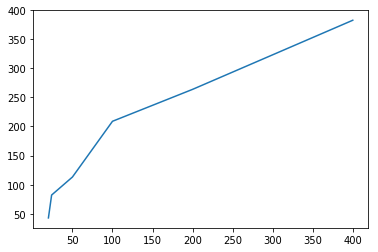

,run,k,num_nodes,activation_func,dropout_rate,init,mse,r2
5,6,20,20,relu,0,normal,42.593395,0.974491
4,5,20,9,relu,0,normal,65.127513,0.960995
10,11,24,9,relu,0,normal,81.963017,0.950912
11,12,24,20,relu,0,normal,99.043398,0.940682
17,18,50,20,relu,0,normal,112.992549,0.932328
9,10,24,8,relu,0,normal,166.475966,0.900297
21,22,100,8,relu,0,normal,208.910885,0.874882
1,2,20,5,relu,0,normal,234.362279,0.859639
7,8,24,5,relu,0,normal,238.358289,0.857246
18,19,100,3,relu,0,normal,246.177834,0.852563


In [36]:
#Grid search evaluation of 3-hidden layers NN based on MSE

eval_results = pd.read_excel('results_3hl.xlsx').reset_index(drop=True)

best_of_ks = eval_results.groupby(['k'])['mse'].min().reset_index(drop=False).sort_values('k')

plt.plot(best_of_ks.k, best_of_ks.mse)
plt.show()   

#top 10 h-parameters sets
top10 = eval_results.sort_values('mse')
top10.head(10)

Epoch 1/200
780/780 [==============================] - 1s 1ms/step - loss: 6026.2201 - mean_squared_error: 6026.2201
Epoch 2/200
780/780 [==============================] - 0s 66us/step - loss: 5920.5934 - mean_squared_error: 5920.5934
Epoch 3/200
780/780 [==============================] - 0s 67us/step - loss: 5229.8897 - mean_squared_error: 5229.8897
Epoch 4/200
780/780 [==============================] - 0s 68us/step - loss: 3133.5468 - mean_squared_error: 3133.5468
Epoch 5/200
780/780 [==============================] - 0s 67us/step - loss: 2018.6718 - mean_squared_error: 2018.6718
Epoch 6/200
780/780 [==============================] - 0s 67us/step - loss: 1458.6579 - mean_squared_error: 1458.6579
Epoch 7/200
780/780 [==============================] - 0s 69us/step - loss: 1030.5425 - mean_squared_error: 1030.5425
Epoch 8/200
780/780 [==============================] - 0s 69us/step - loss: 828.0868 - mean_squared_error: 828.0868
Epoch 9/200
780/780 [==============================] - 0s 6

780/780 [==============================] - 0s 81us/step - loss: 13.6902 - mean_squared_error: 13.6902
Epoch 142/200
780/780 [==============================] - 0s 81us/step - loss: 15.9556 - mean_squared_error: 15.9556
Epoch 143/200
780/780 [==============================] - 0s 74us/step - loss: 14.7449 - mean_squared_error: 14.7449
Epoch 144/200
780/780 [==============================] - 0s 80us/step - loss: 13.0495 - mean_squared_error: 13.0495
Epoch 145/200
780/780 [==============================] - 0s 71us/step - loss: 12.8567 - mean_squared_error: 12.8567
Epoch 146/200
780/780 [==============================] - ETA: 0s - loss: 12.3731 - mean_squared_error: 12.37 - 0s 95us/step - loss: 12.8256 - mean_squared_error: 12.8256
Epoch 147/200
780/780 [==============================] - 0s 95us/step - loss: 13.5612 - mean_squared_error: 13.5612
Epoch 148/200
780/780 [==============================] - 0s 87us/step - loss: 12.8951 - mean_squared_error: 12.8951
Epoch 149/200
780/780 [=========

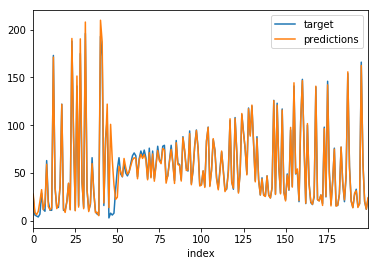

In [38]:
#Best h-parameters for 3-hidden layers NN 

#num_nodes: 20
#k: 20
#activation_func: Relu
#dropout_rate: 0
#init: weight initialization; Normal

model = simple_nn(20, 20, 'relu', 0, 'normal')

#create train/validation
X_train, y_train, X_val, y_val = prepare_datasets(time_series, 20)

#fit on train set
model.fit(X_train, y_train, epochs=200, batch_size=50, verbose=1)

#validation set results 
predictions = model.predict(X_val)
predictions = pd.DataFrame(predictions)

comparison = pd.concat([y_val, predictions], axis = 1)
comparison = comparison.rename(columns={0: 'predictions'}).reset_index(drop=False)
comparison.plot(x='index', y=['target', 'predictions'], label=['target', 'predictions'])
plt.show()

mse_3hl = mean_squared_error(comparison.target,comparison.predictions)
r_squared_3hl = r2_score(comparison.target,comparison.predictions)

#%%        

vertical_data, horizontal_data = predict_next_x(time_series, 20, 200, model);        
        
last_predictions3 = vertical_data.tail(200).reset_index(drop=True)        
last_predictions3 = last_predictions3.rename(columns={'target': 'predictions'}) 

#to excel 
writer = pd.ExcelWriter('final_predictions.xlsx', engine='xlsxwriter');
last_predictions3.to_excel(writer, sheet_name= 'last_predictions');
writer.save();    

### Take and plot the predicted next 200 observations saved

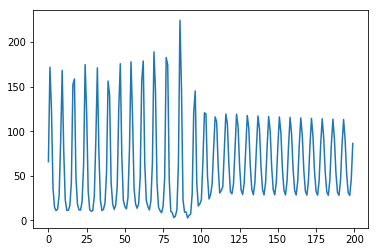

In [5]:
final_predictions = pd.read_excel('final_predictions.xlsx')
plt.plot(final_predictions.time, final_predictions.predictions)
plt.show()  